In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from AVN import *
import pandas as pd
import scipy.io as scp
import os
from Restructure import *
from new_K_seismicity_rate3 import *
import matplotlib.patheffects as pe

In [2]:
###Define colors code for plots:
from matplotlib import cm

##Get colors : 
cmap_name1 = cm.get_cmap('tab20', 20)
cmap_name2 = cm.get_cmap('tab20b', 20)
cmap_name3 = cm.get_cmap('tab20c', 20)
cmap_name4 = cm.get_cmap('tab10', 10)
cmap_name5 = cm.get_cmap('Set3', 12)

cmap1 = cmap_name1(np.linspace(0, 1, 20))
cmap2 = cmap_name2(np.linspace(0, 1, 20))
cmap3 = cmap_name3(np.linspace(0, 1, 20))
cmap4 = cmap_name4(np.linspace(0, 1, 10))
cmap5 = cmap_name5(np.linspace(0, 1, 12))

cmap = np.vstack([cmap1, cmap2, cmap3, cmap4, cmap5, 
                  cmap1, cmap2, cmap3, cmap4, cmap5, 
                  cmap1, cmap2, cmap3, cmap4, cmap5,
                  cmap1, cmap2, cmap3, cmap4, cmap5,
                  cmap1, cmap2, cmap3, cmap4, cmap5])
print(len(cmap))

410


In [3]:
#path_to_df0 = "/Users/louise/Desktop/new_all_run_files_for_etas/catalog_all/"
#
path_to_df0 = "/home/xianglo/Bureau/DATA_AMATRICE/DBSCAN_David/new_all_run_files_for_etas/catalog_all/"

####Raw data:
df0 = pd.read_csv(path_to_df0+'raw_data_modified_version.csv')
###Structure : t, x, y, z, m, x_km, y_km

###Clusters from dbscan:
v0_n50_d0_3 = scp.loadmat("dbscan_data/v0_d03km_n50_every1.mat")["clusters"].reshape(-1) ##au moins 50 séismes à < 200 m, v = 0km/d : 1 séisme sur 5 comme vertex

###Add columns:
df0["dbscan"] = v0_n50_d0_3

###Swarms obtained by ETAS & seismicity rate:
df_swarms = pd.read_csv('v0_d03_n50_every1_clusters/df_final_swarms_of_v0_d03_n50_every1.csv')

##Rename swarms after sorting along t1:
df_swarms = df_swarms.sort_values("t1")
df_swarms.index = np.arange(0, len(df_swarms))

df_swarms

,t1,t2,x1,x2,y1,y2,z1,z2,num_EQ
0,13.534078,16.936724,42.763,42.771,13.153,13.163,5.301,6.640,31
1,21.189318,23.352065,42.512,42.518,13.414,13.421,9.786,10.828,30
2,31.959698,34.152999,42.905,42.914,13.173,13.183,4.573,5.337,52
3,33.400373,35.318887,42.766,42.773,13.219,13.227,6.343,7.093,97
4,43.213940,47.283527,42.896,42.905,13.219,13.228,2.722,3.792,50
5,54.623879,57.830113,42.632,42.653,13.287,13.310,6.468,7.906,27
6,56.921319,57.148958,42.863,42.881,13.066,13.090,1.165,3.237,114
7,72.571283,76.237535,42.523,42.529,13.451,13.464,9.863,11.278,124
8,82.026167,86.479576,42.763,42.770,13.101,13.110,4.584,5.328,162
9,89.020661,90.444182,42.458,42.473,13.239,13.256,6.073,7.706,175


In [4]:
###Create a column of swarms number:
df0["swarms_num"] = np.zeros(len(df0)) -1


for i in range(0, len(df_swarms)):
    select_swarms = df0.index[(df0.t >= df_swarms.t1.iloc[i])&(df0.t <= df_swarms.t2.iloc[i])
                       & (df0.x >= df_swarms.x1.iloc[i])&(df0.x <= df_swarms.x2.iloc[i])
                       & (df0.y >= df_swarms.y1.iloc[i])&(df0.y <= df_swarms.y2.iloc[i])
                       & (df0.z >= df_swarms.z1.iloc[i])&(df0.z <= df_swarms.z2.iloc[i])]
    
    df0.swarms_num.iloc[select_swarms] = i

df0['swarms_num'] = df0['swarms_num'].astype(int)
df0['dbscan'] = df0['dbscan'].astype(int)

print(df0["swarms_num"].max()+1)

###Remove all rows with a magnitude equal to a nan value:
df0 = df0.dropna()

df0.index = np.arange(0, len(df0))

df0

41


,t,x,y,z,m,x_km,y_km,dbscan,swarms_num
0,0.004465,42.99118,12.92042,4.107,0.547416,4780.401106,1050.875824,2,-1
1,0.024991,42.30519,13.68531,6.154,0.964305,4704.122499,1125.431260,0,-1
2,0.028414,43.52994,12.65680,14.826,0.025395,4840.308485,1020.365169,0,-1
3,0.030136,43.16713,12.99694,8.917,-0.127835,4799.965854,1054.068313,0,-1
4,0.043938,43.31555,12.55297,3.274,-0.889339,4816.469405,1015.584715,0,-1
...,...,...,...,...,...,...,...,...,...
894438,365.996726,42.81393,13.10829,7.216,-0.325824,4760.691806,1069.225754,233,-1
894439,365.997166,42.80558,13.14988,3.126,0.304970,4759.763328,1072.763006,0,-1
894440,365.997419,43.00835,13.14668,1.336,-0.183670,4782.310323,1068.979802,225,-1
894441,365.999614,42.66073,13.21744,4.262,-0.273458,4743.656743,1080.795874,0,-1


In [5]:
from AVN import *

###Define AVN MS:
A, V, N, df_AVN = AVN(df0)

df_AVN

,t,x,y,z,m,x_km,y_km,dbscan,swarms_num
621,9.067054,42.71446,13.24279,3.276,6.046692,4749.631246,1081.932511,0.0,-1.0
184899,72.804244,42.91094,13.13936,2.605,5.576763,4771.478826,1070.077358,0.0,-1.0
201811,76.277989,42.83603,13.12131,6.104,6.074127,4763.149214,1069.905228,233.0,-1.0


In [6]:
###Rescale on Norcia event:
xN_km = df0.x_km - N.x_km
yN_km = df0.y_km - N.y_km

df0["xN_km"] = xN_km
df0["yN_km"] = yN_km

###Define AVN MS:
A, V, N, df_AVN = AVN(df0)

###Define EQ m >= 5: ##associated to gold color
df0_m5 = df0[df0.m >= 5]

df0

,t,x,y,z,m,x_km,y_km,dbscan,swarms_num,xN_km,yN_km
0,0.004465,42.99118,12.92042,4.107,0.547416,4780.401106,1050.875824,2,-1,17.251893,-19.029404
1,0.024991,42.30519,13.68531,6.154,0.964305,4704.122499,1125.431260,0,-1,-59.026715,55.526032
2,0.028414,43.52994,12.65680,14.826,0.025395,4840.308485,1020.365169,0,-1,77.159272,-49.540059
3,0.030136,43.16713,12.99694,8.917,-0.127835,4799.965854,1054.068313,0,-1,36.816640,-15.836915
4,0.043938,43.31555,12.55297,3.274,-0.889339,4816.469405,1015.584715,0,-1,53.320191,-54.320513
...,...,...,...,...,...,...,...,...,...,...,...
894438,365.996726,42.81393,13.10829,7.216,-0.325824,4760.691806,1069.225754,233,-1,-2.457408,-0.679474
894439,365.997166,42.80558,13.14988,3.126,0.304970,4759.763328,1072.763006,0,-1,-3.385886,2.857778
894440,365.997419,43.00835,13.14668,1.336,-0.183670,4782.310323,1068.979802,225,-1,19.161110,-0.925426
894441,365.999614,42.66073,13.21744,4.262,-0.273458,4743.656743,1080.795874,0,-1,-19.492471,10.890646


### General view:

## Trying to redetermine t starting swarm:

In [8]:
# %%time 

#%matplotlib inline

def get_new_df_clusters(list0, Plots1 = False, Plots2 = False):
    
    ##Take a deeper look on swarms:
    #path = "/Users/louise/Desktop/new_all_run_files_for_etas/v0_d03_n50_every1_clusters/output_dbscan_v0_d03_n50_every1/"
    #
    path = "/home/xianglo/Bureau/DATA_AMATRICE/DBSCAN_David/new_all_run_files_for_etas/v0_d03_n50_every1_clusters/output_dbscan_v0_d03_n50_every1/"

    ratio_factor = 10

    all_x1 = []
    all_x2 = []
    all_y1 = []
    all_y2 = []
    all_z1 = []
    all_z2 = []
    all_t1 = []
    all_t2 = []
    all_dbscan_cluster = []
    all_swarms_num = []
    
    all_new_t1 = []
    all_dt1 = []
    all_t = []
    all_dn = []

    for num_swarms in list0:
        
        print("###########################swarm n°"+str(num_swarms)+"###########################")
        all_swarms_num.append(num_swarms)

        ###Get dbscan cluster of the studied swarm:
        num_cluster_DBSCAN = df_swarms.num_EQ.iloc[int(num_swarms)]
        all_dbscan_cluster.append(num_cluster_DBSCAN)
        print("num_cluster_DBSCAN =", num_cluster_DBSCAN)

        ###Get dn value used for seismicity rate of dbscan cluster:
        df2 = np_to_pd_3(path+"dbscan_clust"+str(num_cluster_DBSCAN)+".dat")
        df00 = df2[df2.ind == 1]
        df1 = np.cumsum(df00.ind)
        dn = int(np.ceil(len(df00)*5/100)) ##smooth windown ##taking 5% of cluster's data
        print("dn =", dn)
        all_dn.append(dn)

        ###About DBSCAN cluster:
        df_DBCSAN_cluster = df0[df0.dbscan == num_cluster_DBSCAN] 

        ###The swarm is supposed to start at index:
        t_start = df_DBCSAN_cluster[df_DBCSAN_cluster.swarms_num == num_swarms].iloc[0]

        ###If we want redetermine this t_start by taking into account dn:
        arg0 = np.argwhere(df_DBCSAN_cluster.index == t_start.name)[0][0]
        if arg0 <= int(dn):
            arg = 0
        else:
            arg = np.argwhere(df_DBCSAN_cluster.index == t_start.name)[0][0] - int(dn)

        new_t_start = df_DBCSAN_cluster.iloc[arg].t
        print("new_t_start=", round(new_t_start,2), "before t_start=", round(t_start.t,2), "in d")
        all_new_t1.append(new_t_start)
        all_dt1.append(np.abs(round(new_t_start,2) - round(t_start.t,2)))

        ###Redefine swarm limits:
        select_swarms = df0[df0.swarms_num == num_swarms]

        new_select_swarms = df_DBCSAN_cluster[(df_DBCSAN_cluster.t >= new_t_start)&(df_DBCSAN_cluster.t <= round(select_swarms.t.max(), 2))
                      & (df_DBCSAN_cluster.x >= select_swarms.x.min())&(df_DBCSAN_cluster.x <= select_swarms.x.max())
                      & (df_DBCSAN_cluster.y >= select_swarms.y.min())&(df_DBCSAN_cluster.y <= select_swarms.y.max())
                      & (df_DBCSAN_cluster.z >= select_swarms.z.min())&(df_DBCSAN_cluster.z <= select_swarms.z.max())]
        
        centro = np.array([np.mean(new_select_swarms.t.values),
                       np.mean(new_select_swarms.y_km.values),
                       np.mean(new_select_swarms.x_km.values), 
                       np.mean(new_select_swarms.z.values)])

        all_x1.append(round(new_select_swarms.x.min(),3))
        all_x2.append(round(new_select_swarms.x.max(),3))
        all_y1.append(round(new_select_swarms.y.min(),3))
        all_y2.append(round(new_select_swarms.y.max(),3))
        all_z1.append(round(new_select_swarms.z.min(),3))
        all_z2.append(round(new_select_swarms.z.max(),3))
        all_t1.append(t_start.t) ##new t_start --> Modification, we put here the original t_start
        all_t2.append(new_select_swarms.t.max()) ##doesn't change, the end of the swarm is still the same

        ###Duration of swarm:
        duration = new_select_swarms.t.max() - new_select_swarms.t.min() ##end of teh swarm - new t_start
        print("(new) swarm duration =", np.ceil(duration), "d")

        ###Parameter:
        t = np.ceil(duration)*1.25 ##d
        print("parameter t =", t, "d")
        all_t.append(t)

        ###Compute seismicity rate:                    
        ###Observed data: 
        dff = df1
        EQ1_rate = seismicity_rate2 (dn, df00, dff)

        ###The model data:
        dff = df00.lam
        EQ2_rate = seismicity_rate2 (dn, df00, dff)

        ###obs/mod:
        ratio = EQ1_rate/EQ2_rate

        ###About ylim:
        ind = df1[(df00.t >= new_select_swarms.t.min())&(df00.t <= new_select_swarms.t.max())]
        ind2 = df00.lam[(df00.t >= new_select_swarms.t.min())&(df00.t <= new_select_swarms.t.max())]
        print("Observed data: Nb of EQ recorded =", round(ind.max() - ind.min() +1,2)) ##zéro compris!
        print("Model data: Nb of EQ predicted =", round(ind2.max()- ind2.min() +1,2)) ##zéro compris!    

        ###Plots:
        if Plots1:
            plt.figure(figsize=(18,5))
            plt.plot(df00.t,ratio)
            plt.xlabel("Time (d)")
            plt.ylabel("Ratio (obs/mod)")
            plt.axhline(y=ratio_factor, linewidth=2, color=cmap[int(num_swarms)], ls = '--')
            plt.axvline(x=new_select_swarms.t.min(), linewidth=2, color=cmap[int(num_swarms)], ls = '--')
            plt.axvline(x=t_start.t, linewidth=2, color='gray', ls = '--')
            plt.axvline(x=new_select_swarms.t.max(), linewidth=2, color=cmap[int(num_swarms)], ls = '--')
            plt.grid(True)
            plt.show()

            plt.figure(figsize=(18,10))
            plt.subplot(2,1,1)
            plt.plot(df00.t, df1, '-k', label="observed data")
            plt.plot(df00.t, df00.lam, c='crimson', label="model")
            plt.axvline(x=new_select_swarms.t.min(), linewidth=2, color=cmap[int(num_swarms)], ls = '--')
            plt.axvline(x=t_start.t, linewidth=2, color='gray', ls = '--')
            plt.axvline(x=new_select_swarms.t.max(), linewidth=2, color=cmap[int(num_swarms)], ls = '--')
            plt.xlabel("Time (d)")
            plt.ylabel("Cumulative seismic events")
            plt.xlim(new_select_swarms.t.min()-t, new_select_swarms.t.max()+t)
            plt.ylim(np.min([ind.iloc[0], ind2.iloc[0]])-100, df2.lam.max())
            plt.grid(True)
            plt.legend()

            plt.subplot(2,1,2)
            plt.plot(df00.t, EQ1_rate, '-k', label = "observed data")
            plt.plot(df00.t, EQ2_rate, c = "crimson", label = "model")
            plt.xlabel("Time (d)")
            plt.ylabel("Seismicity rate")
            plt.yscale("log")
            plt.axvline(x=new_select_swarms.t.min(), linewidth=2, color=cmap[int(num_swarms)], ls = '--')
            plt.axvline(x=t_start.t, linewidth=2, color='gray', ls = '--')
            plt.axvline(x=new_select_swarms.t.max(), linewidth=2, color=cmap[int(num_swarms)], ls = '--')
            plt.xlim(new_select_swarms.t.min()-t, new_select_swarms.t.max()+t)
            plt.ylim(0, np.max([EQ1_rate, EQ2_rate]))
            plt.grid(True)
            plt.legend()

            plt.tight_layout()
            plt.show()

        ###At -t <=> t days before the occurence of the swarm:
        swarms_bf = df0[(df0.t >= round(new_select_swarms.t.min()-t, 2))&(df0.t <= new_select_swarms.t.min())
                      & (df0.x >= new_select_swarms.x.min())&(df0.x <= new_select_swarms.x.max())
                      & (df0.y >= new_select_swarms.y.min())&(df0.y <= new_select_swarms.y.max())
                      & (df0.z >= new_select_swarms.z.min())&(df0.z <= new_select_swarms.z.max())]
        #At +t <=> t days after the occurence of the swarm:
        swarms_af = df0[(df0.t >= new_select_swarms.t.max())&(df0.t <= round(new_select_swarms.t.max()+t, 2))
                      & (df0.x >= new_select_swarms.x.min())&(df0.x <= new_select_swarms.x.max())
                      & (df0.y >= new_select_swarms.y.min())&(df0.y <= new_select_swarms.y.max())
                      & (df0.z >= new_select_swarms.z.min())&(df0.z <= new_select_swarms.z.max())]

        ##Cluster along the time [swarm0.t - t; swarm0.t + t]:
        swarms_t = df0[(df0.t >= round(new_select_swarms.t.min()-t, 2))&(df0.t <= round(new_select_swarms.t.max()+t, 2))
                      & (df0.x >= new_select_swarms.x.min())&(df0.x <= new_select_swarms.x.max())
                      & (df0.y >= new_select_swarms.y.min())&(df0.y <= new_select_swarms.y.max())
                      & (df0.z >= new_select_swarms.z.min())&(df0.z <= new_select_swarms.z.max())]

        ###About EQ m >= 3.5:
        EQ_m = df0[(df0.t >= round(new_select_swarms.t.min()-t, 2))&(df0.t <= round(new_select_swarms.t.max()+t, 2))
                      & (df0.m >= 3.5)]
        EQ_m = EQ_m.sort_values(["t"], ascending=True)

        ##Distance between those EQ and the centroid of the swarm:
        if EQ_m.empty == False:
            distances = np.sqrt((EQ_m.y_km.values - centro[1])**2 + (EQ_m.x_km.values - centro[2])**2 + (EQ_m.z.values - centro[3])**2) ##euclidean distance in km


        if Plots2:
            ###Plot lat, lon, mag vs t:
            plt.figure(figsize=(18,15))
            plt.subplot(3,1,1)
            plt.scatter(swarms_t.t, swarms_t.yN_km, s=np.exp(4*swarms_t.m), facecolors='none', edgecolors='k', linewidths=1, label='swarm n°'+str(int(num_swarms)))
            #plt.plot(centro[0], centro[1], "*", c='gold', markersize=10)
            if EQ_m.empty == False:
                plt.scatter(EQ_m.t, EQ_m.yN_km, s=np.exp(2*EQ_m.m), facecolors='none', edgecolors='salmon', linewidths=1)
                for j in range(0, len(distances)):
                    plt.annotate(str(abs(int(distances[j]))), (EQ_m.t.iloc[j], EQ_m.y_km.iloc[j]),
                                 color='r', alpha =1, size=13, 
                                #bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.5), 
                                path_effects=[pe.withStroke(linewidth=1, foreground="k")])
    #         plt.scatter(EQ_xy.t, EQ_xy.yN_km, s=6*np.exp(EQ_xy.m), facecolors='none', edgecolors='salmon', linewidths=1)
            if not swarms_t[(swarms_t.t == A.t)].empty == True :
                plt.scatter(A.t, A.yN_km, s=np.exp(A.m), marker='*', edgecolors='tab:red', linewidths=1)
            if not swarms_t[(swarms_t.t == V.t)].empty == True :
                plt.scatter(V.t, V.yN_km, s=np.exp(V.m), marker='*', edgecolors='tab:red', linewidths=1)
            if not swarms_t[(swarms_t.t == N.t)].empty == True :
                plt.scatter(N.t, N.yN_km, s=np.exp(N.m), marker='*', edgecolors='tab:red', linewidths=1)
            plt.axvline(x=new_select_swarms.t.min(), linewidth=2, color=cmap[int(num_swarms)], ls = '--')
            plt.axvline(x=t_start.t, linewidth=2, color='gray', ls = '--')
            plt.axvline(x=new_select_swarms.t.max(), linewidth=2, color=cmap[int(num_swarms)], ls = '--')
            plt.axhline(y=df_DBCSAN_cluster.yN_km.min(), linewidth=2, color='lavender', ls = '--')
            plt.axhline(y=df_DBCSAN_cluster.yN_km.max(), linewidth=2, color='lavender', ls = '--')
            plt.xlim(new_select_swarms.t.iloc[0]-t, new_select_swarms.t.iloc[-1]+t)
            plt.ylim(swarms_t.yN_km.min()-5, swarms_t.yN_km.max()+5)
            plt.xlabel("Time (d)")
            plt.ylabel("Longitude (km)")
            plt.grid(True)

            plt.subplot(3,1,2)
            plt.scatter(swarms_t.t, swarms_t.xN_km, s=np.exp(4*swarms_t.m), facecolors='none', edgecolors='k', linewidths=1, label='swarm n°'+str(int(num_swarms)))
            #plt.plot(centro[0], centro[2], "*", c='gold', markersize=10)
            if EQ_m.empty == False:
                plt.scatter(EQ_m.t, EQ_m.xN_km, s=np.exp(2*EQ_m.m), facecolors='none', edgecolors='salmon', linewidths=1)
                for j in range(0, len(distances)):
                    plt.annotate(str(abs(int(distances[j]))), (EQ_m.t.iloc[j], EQ_m.x_km.iloc[j]),
                                 color='r', alpha =1, size=13, 
                                #bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.5), 
                                path_effects=[pe.withStroke(linewidth=1, foreground="k")])

    #         plt.scatter(EQ_xy.t, EQ_xy.xN_km, s=6*np.exp(EQ_xy.m), facecolors='none', edgecolors='salmon', linewidths=1)
            if not swarms_t[(swarms_t.t == A.t)].empty == True :
                plt.scatter(A.t, A.xN_km, s=np.exp(A.m), marker='*', edgecolors='tab:red', linewidths=1)
            if not swarms_t[(swarms_t.t == V.t)].empty == True :
                plt.scatter(V.t, V.xN_km, s=np.exp(V.m), marker='*', edgecolors='tab:red', linewidths=1)
            if not swarms_t[(swarms_t.t == N.t)].empty == True :
                plt.scatter(N.t, N.xN_km, s=np.exp(N.m), marker='*', edgecolors='tab:red', linewidths=1)
            plt.axvline(x=new_select_swarms.t.min(), linewidth=2, color=cmap[int(num_swarms)], ls = '--')
            plt.axvline(x=t_start.t, linewidth=2, color='gray', ls = '--')
            plt.axvline(x=new_select_swarms.t.max(), linewidth=2, color=cmap[int(num_swarms)], ls = '--')
            plt.axhline(y=df_DBCSAN_cluster.xN_km.min(), linewidth=2, color='lavender', ls = '--')
            plt.axhline(y=df_DBCSAN_cluster.xN_km.max(), linewidth=2, color='lavender', ls = '--')
            plt.xlim(new_select_swarms.t.iloc[0]-t, new_select_swarms.t.iloc[-1]+t)
            plt.ylim(swarms_t.xN_km.min()-5, swarms_t.xN_km.max()+5)
            plt.xlabel("Time (d)")
            plt.ylabel("Latitude(km)")
            plt.grid(True)

            plt.subplot(3,1,3)
            plt.scatter(swarms_t.t, swarms_t.m, s=np.exp(4*swarms_t.m), facecolors='none', edgecolors='k', linewidths=1, label='swarm n°'+str(int(num_swarms)))
            if EQ_m.empty == False:
                plt.scatter(EQ_m.t, EQ_m.m, s=np.exp(2*EQ_m.m), facecolors='none', edgecolors='salmon', linewidths=1)
                for j in range(0, len(distances)):
                    plt.annotate(str(abs(int(distances[j]))), (EQ_m.t.iloc[j], EQ_m.m.iloc[j]),
                                 color='r', alpha =1, size=13, 
                                #bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.5), 
                                path_effects=[pe.withStroke(linewidth=1, foreground="k")])

    #         plt.scatter(EQ_xy.t, EQ_xy.m, s=np.exp(2*EQ_xy.m), facecolors='none', edgecolors='salmon', linewidths=1)
            if not swarms_t[(swarms_t.t == A.t)].empty == True :
                plt.scatter(A.t, A.m, s=np.exp(A.m), marker='*', edgecolors='tab:red', linewidths=1)
            if not swarms_t[(swarms_t.t == V.t)].empty == True :
                plt.scatter(V.t, V.m, s=np.exp(V.m), marker='*', edgecolors='tab:red', linewidths=1)
            if not swarms_t[(swarms_t.t == N.t)].empty == True :
                plt.scatter(N.t, N.m, s=np.exp(N.m), marker='*', edgecolors='tab:red', linewidths=1)
            plt.axvline(x=new_select_swarms.t.min(), linewidth=2, color=cmap[int(num_swarms)], ls = '--')
            plt.axvline(x=t_start.t, linewidth=2, color='gray', ls = '--')
            plt.axvline(x=new_select_swarms.t.max(), linewidth=2, color=cmap[int(num_swarms)], ls = '--')
            plt.axhline(y=df_DBCSAN_cluster.m.min(), linewidth=2, color='lavender', ls = '--')
            plt.axhline(y=df_DBCSAN_cluster.m.max(), linewidth=2, color='lavender', ls = '--')
            plt.xlim(new_select_swarms.t.iloc[0]-t, new_select_swarms.t.iloc[-1]+t)
            plt.xlabel("Time (d)")
            plt.ylabel("Magnitude ")
            plt.grid(True)

            plt.tight_layout()
            plt.show()

            ###Plots map along the time t:
            plt.figure(figsize=(18,10))
            plt.subplot(1,3,1)
            plt.scatter(swarms_bf.yN_km, swarms_bf.xN_km, s=np.exp(4*swarms_bf.m), facecolors='none', edgecolors='k', linewidths=0.5, label='EQ')
            plt.xlabel("Longitude (km)")
            plt.ylabel("Latitude (km)")
            plt.title("Localization of swarm n°"+str(int(num_swarms))+", \n for t = ["+str(round(swarms_bf.t.iloc[0],1))+";"+str(round(swarms_bf.t.iloc[-1],1))+"] d")
            plt.xlim(new_select_swarms.yN_km.min(), new_select_swarms.yN_km.max())
            plt.ylim(new_select_swarms.xN_km.min(), new_select_swarms.xN_km.max())
            plt.gca().set_aspect('equal', adjustable='box')
            plt.grid(True)

            plt.subplot(1,3,2)
            plt.scatter(select_swarms.yN_km, select_swarms.xN_km, s=np.exp(4*select_swarms.m), facecolors='none', edgecolors='k', linewidths=0.5, label='EQ')
            plt.xlabel("Longitude (km)")
            plt.ylabel("Latitude (km)")
            plt.title("Localization of swarm n°"+str(int(num_swarms))+", \n for t = ["+str(round(select_swarms.t.iloc[0],1))+";"+str(round(select_swarms.t.iloc[-1],1))+"] d")
            plt.xlim(new_select_swarms.yN_km.min(), new_select_swarms.yN_km.max())
            plt.ylim(new_select_swarms.xN_km.min(), new_select_swarms.xN_km.max())
            plt.gca().set_aspect('equal', adjustable='box')
            plt.grid(True)

            plt.subplot(1,3,3)
            plt.scatter(swarms_af.yN_km, swarms_af.xN_km, s=np.exp(4*swarms_af.m), facecolors='none', edgecolors='k', linewidths=0.5, label='EQ')
            plt.xlabel("Longitude (km)")
            plt.ylabel("Latitude (km)")
            plt.title("Localization of swarm n°"+str(int(num_swarms))+", \n for t = ["+str(round(swarms_af.t.iloc[0],1))+";"+str(round(swarms_af.t.iloc[-1],1))+"] d")
            plt.xlim(new_select_swarms.yN_km.min(), new_select_swarms.yN_km.max())
            plt.ylim(new_select_swarms.xN_km.min(), new_select_swarms.xN_km.max())
            plt.gca().set_aspect('equal', adjustable='box')
            plt.grid(True)

            plt.tight_layout()
            plt.show()

    # ###Create a new df:
    all_x1 = np.array(all_x1)
    all_x2 = np.array(all_x2)
    all_y1 = np.array(all_y1)
    all_y2 = np.array(all_y2)
    all_z1 = np.array(all_z1)
    all_z2 = np.array(all_z2)
    all_t1 = np.array(all_t1)
    all_t2 = np.array(all_t2)
    all_dbscan_cluster = np.array(all_dbscan_cluster)
    all_swarms_num = np.array(all_swarms_num)
    
    all_new_t1 = np.array(all_new_t1)
    all_dt1 = np.array(all_dt1)
    all_t = np.array(all_t)
    all_dn = np.array(all_dn)

    data = {"t1": all_t1, "t2":all_t2, "x1":all_x1, "x2":all_x2, "y1":all_y1, "y2":all_y2,
            "z1":all_z1, "z2":all_z2, "num_EQ":all_dbscan_cluster, "swarms_num":all_swarms_num, 
            "new_t1": all_new_t1, "dt1": all_dt1, "t": all_t, "dn": all_dn}
    new_df_list0 = pd.DataFrame(data)
    
    return new_df_list0

In [9]:
%%time

list0 = np.arange(0, len(df_swarms))
new_df_list0 = get_new_df_clusters (list0, Plots1 = False, Plots2 = False)


###########################swarm n°0###########################
num_cluster_DBSCAN = 31
dn = 17
new_t_start= 10.69 before t_start= 13.53 in d
(new) swarm duration = 6.0 d
parameter t = 7.5 d
Observed data: Nb of EQ recorded = 193.0
Model data: Nb of EQ predicted = 36.06
###########################swarm n°1###########################
num_cluster_DBSCAN = 30


/home/xianglo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in true_divide


dn = 8
new_t_start= 13.14 before t_start= 21.2 in d
(new) swarm duration = 11.0 d
parameter t = 13.75 d
Observed data: Nb of EQ recorded = 90.0
Model data: Nb of EQ predicted = 9.26
###########################swarm n°2###########################
num_cluster_DBSCAN = 52
dn = 8
new_t_start= 30.82 before t_start= 31.97 in d
(new) swarm duration = 4.0 d
parameter t = 5.0 d
Observed data: Nb of EQ recorded = 72.0
Model data: Nb of EQ predicted = 6.18
###########################swarm n°3###########################
num_cluster_DBSCAN = 97
dn = 5
new_t_start= 21.48 before t_start= 33.4 in d
(new) swarm duration = 2.0 d
parameter t = 2.5 d
Observed data: Nb of EQ recorded = 71.0
Model data: Nb of EQ predicted = 2.69
###########################swarm n°4###########################
num_cluster_DBSCAN = 50
dn = 10
new_t_start= 39.5 before t_start= 43.21 in d
(new) swarm duration = 8.0 d
parameter t = 10.0 d
Observed data: Nb of EQ recorded = 98.0
Model data: Nb of EQ predicted = 12.13
#############

dn = 9
new_t_start= 238.87 before t_start= 241.72 in d
(new) swarm duration = 4.0 d
parameter t = 5.0 d
Observed data: Nb of EQ recorded = 162.0
Model data: Nb of EQ predicted = 2.96
###########################swarm n°32###########################
num_cluster_DBSCAN = 215
dn = 86
new_t_start= 189.16 before t_start= 249.29 in d
(new) swarm duration = 63.0 d
parameter t = 78.75 d
Observed data: Nb of EQ recorded = 493.0
Model data: Nb of EQ predicted = 320.7
###########################swarm n°33###########################
num_cluster_DBSCAN = 103
dn = 162
new_t_start= 214.88 before t_start= 272.01 in d
(new) swarm duration = 58.0 d
parameter t = 72.5 d
Observed data: Nb of EQ recorded = 322.0
Model data: Nb of EQ predicted = 313.64
###########################swarm n°34###########################
num_cluster_DBSCAN = 267
dn = 3
new_t_start= 112.21 before t_start= 280.37 in d
(new) swarm duration = 5.0 d
parameter t = 6.25 d
Observed data: Nb of EQ recorded = 54.0
Model data: Nb of EQ pred

In [10]:
new_df_list0

,t1,t2,x1,x2,y1,y2,z1,z2,num_EQ,swarms_num,new_t1,dt1,t,dn
0,13.534078,16.936724,42.763,42.770,13.154,13.163,5.301,6.640,31,0,10.690895,2.84,7.50,17
1,21.195346,23.248829,42.513,42.517,13.414,13.421,9.786,10.828,30,1,13.137280,8.06,13.75,8
2,31.968791,34.038095,42.906,42.913,13.175,13.182,4.601,5.337,52,2,30.820802,1.15,5.00,8
3,33.400871,35.318887,42.767,42.773,13.219,13.227,6.343,7.093,97,3,21.477573,11.92,2.50,5
4,43.213940,47.259175,42.897,42.905,13.220,13.226,2.824,3.764,50,4,39.503106,3.71,10.00,10
5,54.635766,57.825894,42.639,42.653,13.287,13.305,6.772,7.764,27,5,52.022877,2.62,7.50,55
6,56.923042,57.149496,42.867,42.878,13.070,13.081,1.467,3.049,114,6,56.203129,0.72,1.25,129
7,72.571283,76.237535,42.524,42.529,13.452,13.464,9.899,11.071,124,7,67.119588,5.45,11.25,13
8,82.026167,86.479576,42.763,42.769,13.103,13.109,4.584,5.328,162,8,55.126709,26.90,40.00,7
9,89.024916,90.439672,42.459,42.473,13.239,13.254,6.073,7.616,175,9,61.917275,27.10,36.25,42


## Get new values for stats:

In [11]:
def delay_time_statistics(new_df) :

    ###Time difference in days:

    all_dbscan_cluster = []
    all_param1 = [] ##number of the biggest EQ/ len(swarms) <=> index I
    all_big_t = []  ##no used at the end...
    all_diff_m_start = [] ##o used at the end...
    all_diff_m_from4 = [] ##used
    all_i_stars = [] ##used
    all_skew = []  ##no used at the end...

    for num_swarm in new_df.swarms_num.values :
        
        select_ind_swarm = new_df[new_df.swarms_num == num_swarm].index[0]

        df_clust = 0

        ##Select data:
        df_clust = df0[(df0.t >= new_df.new_t1.iloc[select_ind_swarm])&(df0.t <= new_df.t2.iloc[select_ind_swarm])
                       & (df0.x >= new_df.x1.iloc[select_ind_swarm])&(df0.x <= new_df.x2.iloc[select_ind_swarm])
                       & (df0.y >= new_df.y1.iloc[select_ind_swarm])&(df0.y <= new_df.y2.iloc[select_ind_swarm])
                       & (df0.z >= new_df.z1.iloc[select_ind_swarm])&(df0.z <= new_df.z2.iloc[select_ind_swarm])]
        df_clust.index=np.arange(len(df_clust))
        
        ##Save dbscan cluster origin:
        all_dbscan_cluster.append(new_df.num_EQ.iloc[select_ind_swarm]) 

        ##Compute new t:
        df_clust["new_t"] = df_clust.t - df_clust.t.iloc[0] ##based on new_t1 and df0 !
        
        ##Sort magnitude:
        df_clust = df_clust.sort_values("m", ascending = False)
        
        ##Ratio:
        ratio = df_clust[df_clust.m.values == df_clust.m.max()].index/len(df_clust)
        all_param1.append(ratio)

        ##For swarms, the delay between biggest event and the first event shouldn't be close...

        #######SHEARER 2016:
        ##Compute mean(or median) of new_t:
        tbar = df_clust.new_t.mean()
#         tbar = df_clust.new_t.median()

        ##Attribut T:
        ##Find t of biggest EQ:
        tm = df_clust.new_t[df_clust.m == df_clust.m.max()].values
        big_t = tm/tbar
        all_big_t.append(big_t)

        ##Attribut diff in time between the biggest EQ and other EQ:
        diff_m = df_clust.m[df_clust.m == df_clust.m.max()].values - df_clust.m.values 
        df_clust["diff_m"] = diff_m
        
        ##Attribut diff in magnitude between the 1st biggest EQ and the biggest EQ:
        all_diff_m_start.append(df_clust.diff_m.iloc[1])
        ##Attribut diff in magnitude between the 4th biggest EQ  and the biggest EQ:
        all_diff_m_from4.append(df_clust.diff_m.iloc[3])
            
        ##Attribut t*:
        M = 10**(1.5*df_clust.m.values + 9.1)
        i_stars = np.sum(M*df_clust.index+1)/np.sum(M)
        i_stars = i_stars/len(df_clust) #normalized
        all_i_stars.append(i_stars)

        #######SHEARER 2011:
        ##Compute moment release Mo(i):
        Mo = 10**(1.5*df_clust.m.values+9.1) 

        ##Compute weight mean time tbar:
        tbar = np.sum(df_clust.new_t.values * Mo)/(np.sum(Mo))

        ##Compute individulal moment normalized mo:
        mo = Mo/np.sum(Mo)

        ##Compute the third central moment mu3:
        mu3 = np.sum((df_clust.new_t - tbar)**3 * mo)

        ##Compute standard deviation sigma:
        sigma = (np.sum((df_clust.new_t - tbar)**2 * mo))**(1/2)

        ##Skewness of moment release skew:
        skew = mu3/sigma
        all_skew.append(skew)
        
    all_dbscan_cluster = np.array(all_dbscan_cluster)
    all_param1 = np.array(all_param1)
    all_big_t = np.array(all_big_t)
    all_diff_m_start = np.array(all_diff_m_start)
    all_diff_m_from4 = np.array(all_diff_m_from4)
    all_i_stars = np.array(all_i_stars)
    all_skew = np.array(all_skew)
    
    data = {"dbscan_cluster":all_dbscan_cluster,
            "param1":all_param1.reshape(-1),
            "T":all_big_t.reshape(-1),
            "i_stars":all_i_stars,
            "diff_m":all_diff_m_from4, 
            "skew":all_skew}
#     print(len(all_dbscan_cluster), len(all_param1), len(all_big_t), len(all_diff_m_from4), len(all_t_stars), len(all_skew))
#     print(all_dbscan_cluster, all_param1, all_big_t, all_diff_m_from4, all_t_stars, all_skew)
    df_final = pd.DataFrame(data)
    
    return df_final

In [12]:
df_stats0 = delay_time_statistics(new_df_list0)
df_stats0["swarm_number"] = list0

df_stats0

/home/xianglo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,dbscan_cluster,param1,T,i_stars,diff_m,skew,swarm_number
0,31,0.250000,0.662528,0.303379,0.137041,1.710040,0
1,30,0.411111,0.983317,0.440875,0.420898,-2.187809,1
2,52,0.695652,1.336619,0.627062,0.282956,-0.530876,2
3,97,0.767123,2.112586,0.426809,0.088357,0.342750,3
4,50,0.380435,0.929220,0.363876,0.410060,0.253656,4
5,27,0.909524,1.797204,0.664263,0.593924,-1.073849,5
6,114,0.274390,0.909410,0.318804,0.889787,-0.019188,6
7,124,0.145455,0.742053,0.334329,0.504603,1.582472,7
8,162,0.909091,1.067740,0.524652,0.094132,-7.161232,8
9,175,0.536630,1.010165,0.528970,0.398199,-3.761757,9


In [13]:
##Concatenate previous table with general characteristics and the table of statistics data:
#new_df_listx: statistics data, df_statsx:general characteristics
df_stats0_ = pd.concat([new_df_list0, df_stats0], ignore_index=True, axis=1, join="inner")
rename_stats0 = np.concatenate([list(new_df_list0.columns), list(df_stats0.columns)])
#df_stats0_.set_axis(rename_stats0, axis=1,inplace=True)
df_stats0_ = df_stats0_.set_axis(axis=1, labels=rename_stats0)
df_stats0_

,t1,t2,x1,x2,y1,y2,z1,z2,num_EQ,swarms_num,...,dt1,t,dn,dbscan_cluster,param1,T,i_stars,diff_m,skew,swarm_number
0,13.534078,16.936724,42.763,42.770,13.154,13.163,5.301,6.640,31,0,...,2.84,7.50,17,31,0.250000,0.662528,0.303379,0.137041,1.710040,0
1,21.195346,23.248829,42.513,42.517,13.414,13.421,9.786,10.828,30,1,...,8.06,13.75,8,30,0.411111,0.983317,0.440875,0.420898,-2.187809,1
2,31.968791,34.038095,42.906,42.913,13.175,13.182,4.601,5.337,52,2,...,1.15,5.00,8,52,0.695652,1.336619,0.627062,0.282956,-0.530876,2
3,33.400871,35.318887,42.767,42.773,13.219,13.227,6.343,7.093,97,3,...,11.92,2.50,5,97,0.767123,2.112586,0.426809,0.088357,0.342750,3
4,43.213940,47.259175,42.897,42.905,13.220,13.226,2.824,3.764,50,4,...,3.71,10.00,10,50,0.380435,0.929220,0.363876,0.410060,0.253656,4
5,54.635766,57.825894,42.639,42.653,13.287,13.305,6.772,7.764,27,5,...,2.62,7.50,55,27,0.909524,1.797204,0.664263,0.593924,-1.073849,5
6,56.923042,57.149496,42.867,42.878,13.070,13.081,1.467,3.049,114,6,...,0.72,1.25,129,114,0.274390,0.909410,0.318804,0.889787,-0.019188,6
7,72.571283,76.237535,42.524,42.529,13.452,13.464,9.899,11.071,124,7,...,5.45,11.25,13,124,0.145455,0.742053,0.334329,0.504603,1.582472,7
8,82.026167,86.479576,42.763,42.769,13.103,13.109,4.584,5.328,162,8,...,26.90,40.00,7,162,0.909091,1.067740,0.524652,0.094132,-7.161232,8
9,89.024916,90.439672,42.459,42.473,13.239,13.254,6.073,7.616,175,9,...,27.10,36.25,42,175,0.536630,1.010165,0.528970,0.398199,-3.761757,9


In [14]:
##Concatenate all df_statsx:
df_stats = df_stats0_
df_stats = df_stats.sort_values("swarm_number")
df_stats.index = np.arange(0, len(df_stats))
df_stats["swarm_number"] = np.arange(1, len(df_stats)+1)

#path = "/Users/louise/Desktop/new_all_run_files_for_etas/v0_d03_n50_every1_clusters/Saving_t_start_df/"
#
path = "/home/xianglo/Bureau/DATA_AMATRICE/DBSCAN_David/new_all_run_files_for_etas/v0_d03_n50_every1_clusters/Saving_t_start_df/"
if not os.path.exists(path):
    os.mkdir(path)

#df_stats.to_csv(path+"df_stats.csv", index=False)

df_stats

,t1,t2,x1,x2,y1,y2,z1,z2,num_EQ,swarms_num,...,dt1,t,dn,dbscan_cluster,param1,T,i_stars,diff_m,skew,swarm_number
0,13.534078,16.936724,42.763,42.770,13.154,13.163,5.301,6.640,31,0,...,2.84,7.50,17,31,0.250000,0.662528,0.303379,0.137041,1.710040,1
1,21.195346,23.248829,42.513,42.517,13.414,13.421,9.786,10.828,30,1,...,8.06,13.75,8,30,0.411111,0.983317,0.440875,0.420898,-2.187809,2
2,31.968791,34.038095,42.906,42.913,13.175,13.182,4.601,5.337,52,2,...,1.15,5.00,8,52,0.695652,1.336619,0.627062,0.282956,-0.530876,3
3,33.400871,35.318887,42.767,42.773,13.219,13.227,6.343,7.093,97,3,...,11.92,2.50,5,97,0.767123,2.112586,0.426809,0.088357,0.342750,4
4,43.213940,47.259175,42.897,42.905,13.220,13.226,2.824,3.764,50,4,...,3.71,10.00,10,50,0.380435,0.929220,0.363876,0.410060,0.253656,5
5,54.635766,57.825894,42.639,42.653,13.287,13.305,6.772,7.764,27,5,...,2.62,7.50,55,27,0.909524,1.797204,0.664263,0.593924,-1.073849,6
6,56.923042,57.149496,42.867,42.878,13.070,13.081,1.467,3.049,114,6,...,0.72,1.25,129,114,0.274390,0.909410,0.318804,0.889787,-0.019188,7
7,72.571283,76.237535,42.524,42.529,13.452,13.464,9.899,11.071,124,7,...,5.45,11.25,13,124,0.145455,0.742053,0.334329,0.504603,1.582472,8
8,82.026167,86.479576,42.763,42.769,13.103,13.109,4.584,5.328,162,8,...,26.90,40.00,7,162,0.909091,1.067740,0.524652,0.094132,-7.161232,9
9,89.024916,90.439672,42.459,42.473,13.239,13.254,6.073,7.616,175,9,...,27.10,36.25,42,175,0.536630,1.010165,0.528970,0.398199,-3.761757,10


In [17]:
import os

###Saving dataframe:
##Create directory for saving refine t_start datframes:
#savedir = "/Users/louise/Desktop/new_all_run_files_for_etas/Saving_t_start_df/"
#
savedir = "/home/xianglo/Bureau/DATA_AMATRICE/DBSCAN_David/new_all_run_files_for_etas/v0_d03_n50_every1_clusters/Saving_t_start_df/"
if not os.path.exists(savedir):
    os.mkdir(savedir)
    
#df_stats0_.to_csv(savedir+"df_stats0_redefine_tstart.csv", index=False)

## Define the final swarms df:

In [18]:
###Concantenate all kind swarms list into a df:
new_df = new_df_list0
###Sort them:
new_df = new_df.sort_values(by=['swarms_num'], ascending=True, ignore_index=True)
###Rename swarm:
new_df["swarms_num"]  = np.arange(1, len(new_df)+1)

###Remove the 1 swarms af:
#new_df = new_df.drop(index=([12+1, 14+1])) ##12 and 14 are after rename step beginning with 0...
new_df = new_df.drop(index=([12+1])) ##only A after meeting 12122023

###Redefine df index after removing af, we keep every other swarms:
new_df.index = np.arange(0, len(new_df))

new_df##nt1 is the redefined t_start of the swarms

,t1,t2,x1,x2,y1,y2,z1,z2,num_EQ,swarms_num,new_t1,dt1,t,dn
0,13.534078,16.936724,42.763,42.770,13.154,13.163,5.301,6.640,31,1,10.690895,2.84,7.50,17
1,21.195346,23.248829,42.513,42.517,13.414,13.421,9.786,10.828,30,2,13.137280,8.06,13.75,8
2,31.968791,34.038095,42.906,42.913,13.175,13.182,4.601,5.337,52,3,30.820802,1.15,5.00,8
3,33.400871,35.318887,42.767,42.773,13.219,13.227,6.343,7.093,97,4,21.477573,11.92,2.50,5
4,43.213940,47.259175,42.897,42.905,13.220,13.226,2.824,3.764,50,5,39.503106,3.71,10.00,10
5,54.635766,57.825894,42.639,42.653,13.287,13.305,6.772,7.764,27,6,52.022877,2.62,7.50,55
6,56.923042,57.149496,42.867,42.878,13.070,13.081,1.467,3.049,114,7,56.203129,0.72,1.25,129
7,72.571283,76.237535,42.524,42.529,13.452,13.464,9.899,11.071,124,8,67.119588,5.45,11.25,13
8,82.026167,86.479576,42.763,42.769,13.103,13.109,4.584,5.328,162,9,55.126709,26.90,40.00,7
9,89.024916,90.439672,42.459,42.473,13.239,13.254,6.073,7.616,175,10,61.917275,27.10,36.25,42


### Based on the initial dataframe:

In [19]:
new_df = df_swarms.copy()
###Remove the 1 swarm af:
#new_df = new_df.drop(index=([12+1, 14+1]))
new_df = new_df.drop(index=([12+1])) ##only A after meeting 12122023
###Redefine df index after removing af, we keep every other swarms:
new_df.index = np.arange(0, len(new_df))

new_df

,t1,t2,x1,x2,y1,y2,z1,z2,num_EQ
0,13.534078,16.936724,42.763,42.771,13.153,13.163,5.301,6.640,31
1,21.189318,23.352065,42.512,42.518,13.414,13.421,9.786,10.828,30
2,31.959698,34.152999,42.905,42.914,13.173,13.183,4.573,5.337,52
3,33.400373,35.318887,42.766,42.773,13.219,13.227,6.343,7.093,97
4,43.213940,47.283527,42.896,42.905,13.219,13.228,2.722,3.792,50
5,54.623879,57.830113,42.632,42.653,13.287,13.310,6.468,7.906,27
6,56.921319,57.148958,42.863,42.881,13.066,13.090,1.165,3.237,114
7,72.571283,76.237535,42.523,42.529,13.451,13.464,9.863,11.278,124
8,82.026167,86.479576,42.763,42.770,13.101,13.110,4.584,5.328,162
9,89.020661,90.444182,42.458,42.473,13.239,13.256,6.073,7.706,175


In [20]:
###We choose to keep the old t_start because it is more accurate... The new t_start is only for the 
###verification/checking step with stats

#new_df.to_csv("v0_d03_n50_every1_clusters/new_df_final_swarms_of_v0_d03_n50_every1.csv", index=False)

## After getting migration behaviour data:

In [21]:
##Concatenate all df_statsx:
df_stats = pd.concat([df_stats0_], ignore_index=True)
df_stats.sort_values("swarm_number", inplace=True)
df_stats.index = np.arange(0, len(df_stats))
df_stats["swarms_num"]  = np.arange(1, len(df_stats)+1)

##Rename AF and swarms:
#
renum = np.concatenate((np.arange(1, 13), [-99], np.arange(13,41))) ##only A after meeting 12122023
#renum = np.concatenate((np.arange(1, 13), [-99], [13], [-99], np.arange(14,40))) ##avec A ET B
df_stats["swarm_number"] = renum

#df_stats.to_csv("/Users/louise/Desktop/new_all_run_files_for_etas/v0_d03_n50_every1_clusters/Saving_t_start_df/df_stats.csv", index=False)
#
df_stats.to_csv("/home/xianglo/Bureau/DATA_AMATRICE/DBSCAN_David/new_all_run_files_for_etas/v0_d03_n50_every1_clusters/Saving_t_start_df/df_stats.csv", index=False)

df_stats.drop(["dt1","t","dn","param1","T","i_stars","diff_m","skew"], axis=1)

,t1,t2,x1,x2,y1,y2,z1,z2,num_EQ,swarms_num,new_t1,dbscan_cluster,swarm_number
0,13.534078,16.936724,42.763,42.770,13.154,13.163,5.301,6.640,31,1,10.690895,31,1
1,21.195346,23.248829,42.513,42.517,13.414,13.421,9.786,10.828,30,2,13.137280,30,2
2,31.968791,34.038095,42.906,42.913,13.175,13.182,4.601,5.337,52,3,30.820802,52,3
3,33.400871,35.318887,42.767,42.773,13.219,13.227,6.343,7.093,97,4,21.477573,97,4
4,43.213940,47.259175,42.897,42.905,13.220,13.226,2.824,3.764,50,5,39.503106,50,5
5,54.635766,57.825894,42.639,42.653,13.287,13.305,6.772,7.764,27,6,52.022877,27,6
6,56.923042,57.149496,42.867,42.878,13.070,13.081,1.467,3.049,114,7,56.203129,114,7
7,72.571283,76.237535,42.524,42.529,13.452,13.464,9.899,11.071,124,8,67.119588,124,8
8,82.026167,86.479576,42.763,42.769,13.103,13.109,4.584,5.328,162,9,55.126709,162,9
9,89.024916,90.439672,42.459,42.473,13.239,13.254,6.073,7.616,175,10,61.917275,175,10


In [22]:
##Add migration swarms:
#dfM = pd.read_csv("/Users/louise/Desktop/new_all_run_files_for_etas/v0_d03_n50_every1_clusters/dfM.csv")
#
dfM = pd.read_csv("/home/xianglo/Bureau/DATA_AMATRICE/DBSCAN_David/new_all_run_files_for_etas/v0_d03_n50_every1_clusters/dfM.csv")

##And without:
#dfNM = pd.read_csv("/Users/louise/Desktop/new_all_run_files_for_etas/v0_d03_n50_every1_clusters/dfNM.csv")
#
dfNM = pd.read_csv("/home/xianglo/Bureau/DATA_AMATRICE/DBSCAN_David/new_all_run_files_for_etas/v0_d03_n50_every1_clusters/dfNM.csv")

dfM

,N,max_m,V2,plana,I,duration,v,swarms
0,180,1.7358,0.0403,0.0669,1,3.4026,0.000133,1
1,86,1.9626,0.0152,0.3706,2,2.0668,0.097782,2
2,69,0.7173,0.0093,0.4461,4,1.9180,0.112986,4
3,90,1.5348,0.0229,0.4009,5,4.0596,0.036495,5
4,161,2.1737,0.0259,0.6164,8,3.6663,0.060144,8
5,523,2.4513,0.1044,0.6143,10,1.4172,0.045565,10
6,102,2.3205,0.0083,0.4228,11,0.5002,0.015355,11
7,251,2.0582,0.0538,0.4356,12,3.1772,0.027905,12
8,1009,2.0887,0.9274,0.1601,13,2.5538,0.024208,13
9,202,2.2569,0.0493,0.4398,14,4.9087,0.017085,14


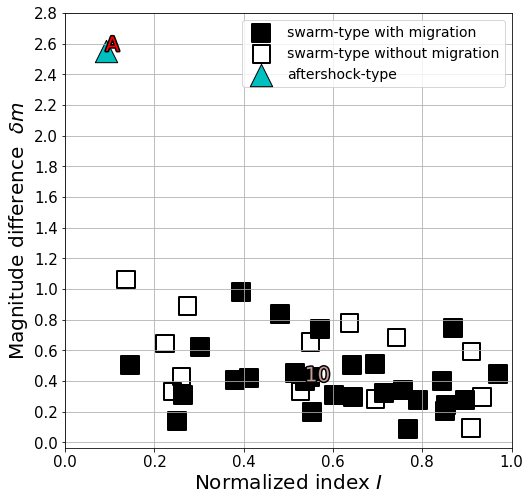

In [29]:
####For paper:
marker_size = 300
marker_size_l = 500

plt.figure(figsize=(8,8))

##Swarms with migration:
for j in dfM.I.values:
    if j == dfM.I.values[0]:
        plt.scatter(df_stats[df_stats.swarm_number == j].param1, df_stats[df_stats.swarm_number == j].diff_m, marker='s', c='k', s=marker_size, linewidth=2, label="swarm-type with migration")
    else:
        plt.scatter(df_stats[df_stats.swarm_number == j].param1, df_stats[df_stats.swarm_number == j].diff_m, marker='s', c='k', s=marker_size, linewidth=2)
    
    if j==10:
        plt.annotate(str(j), 
              (df_stats[df_stats.swarm_number == j].param1, df_stats[df_stats.swarm_number == j].diff_m),
               color=cmap[int(df_stats.swarm_number.iloc[j])], alpha =1, size=20, 
               path_effects=[pe.withStroke(linewidth=3, foreground="k")])

##Swarms without migration:
for j in dfNM.I.values:
    if j == dfNM.I.values[0]:
        plt.scatter(df_stats[df_stats.swarm_number == j].param1, df_stats[df_stats.swarm_number == j].diff_m, marker='s', s=marker_size, linewidth=2, facecolors='none', edgecolors='k', label='swarm-type without migration')
    else:
        plt.scatter(df_stats[df_stats.swarm_number == j].param1, df_stats[df_stats.swarm_number == j].diff_m, marker='s', s=marker_size, linewidth=2, facecolors='none', edgecolors='k')
#     plt.annotate(str(j), 
#                 (df_stats[df_stats.swarm_number == j].param1, df_stats[df_stats.swarm_number == j].diff_m),
#                 color=cmap[int(df_stats.swarm_number.iloc[j])], alpha =1, size=15, 
#                 path_effects=[pe.withStroke(linewidth=1, foreground="k")])
        
##Adding AF:
letters = ["A"]
for i in [12+1]:
    if i == 12+1:
        L = letters[0]
        plt.scatter(df_stats[df_stats.swarms_num == i].param1, df_stats[df_stats.swarms_num == i].diff_m, marker='^', s=marker_size_l, linewidth=1, facecolors='c', edgecolors='k', label="aftershock-type")
    
    plt.annotate(str(L), 
                 (df_stats[df_stats.swarms_num == i].param1, df_stats[df_stats.swarms_num == i].diff_m),
                 color='r', alpha =1, size=20, 
                 path_effects=[pe.withStroke(linewidth=3, foreground="k")])

    
plt.ylabel("Magnitude difference  $\delta m$", fontsize=20)
plt.xlabel("Normalized index $I$", fontsize=20)
plt.tick_params(axis='both',labelsize=15)
plt.legend(fontsize=14)
#plt.axis('scaled')
plt.xlim([0,1])
plt.yticks(np.arange(0,3,0.2))
plt.grid(True)
plt.savefig(path+"Validation_step_dmvsI.png", bbox_inches="tight")
plt.show()